In [ ]:
# place cells

In [38]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys')
from util.paths import find

In [31]:
probe = 'DB_P64-3'

In [3]:
fm_dir = '/home/niell_lab/Kraken/T/freely_moving_ephys/ephys_recordings/070121/G6HCK1ALTRN/fm1'

In [26]:
revchecker_dir = '/home/niell_lab/Kraken/T/freely_moving_ephys/ephys_recordings/070121/G6HCK1ALTRN/hf4_revchecker'
revchecker_ephys_data = pd.read_hdf(find('*ephys_props.h5',revchecker_dir)[0])

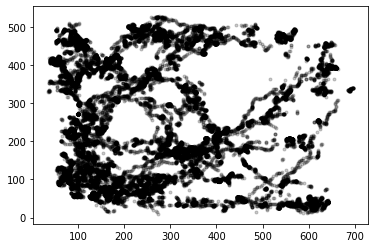

In [5]:
top_dataset = xr.open_dataset(find('*TOP1*.nc',fm_dir)[0])
x_trace = top_dataset.TOP1_pts.sel(point_loc='tailbase_x').values
y_trace = top_dataset.TOP1_pts.sel(point_loc='tailbase_y').values
plt.plot(x_trace, y_trace,'k.',alpha=0.2)

In [7]:
ephys_data = pd.read_hdf(find('*ephys_props.h5',fm_dir)[0])

In [13]:
wn_ephys_data = pd.read_hdf(find('*ephys_props.h5',wn_dir)[0])

In [8]:
goodcells = ephys_data.loc[ephys_data['group']=='good']

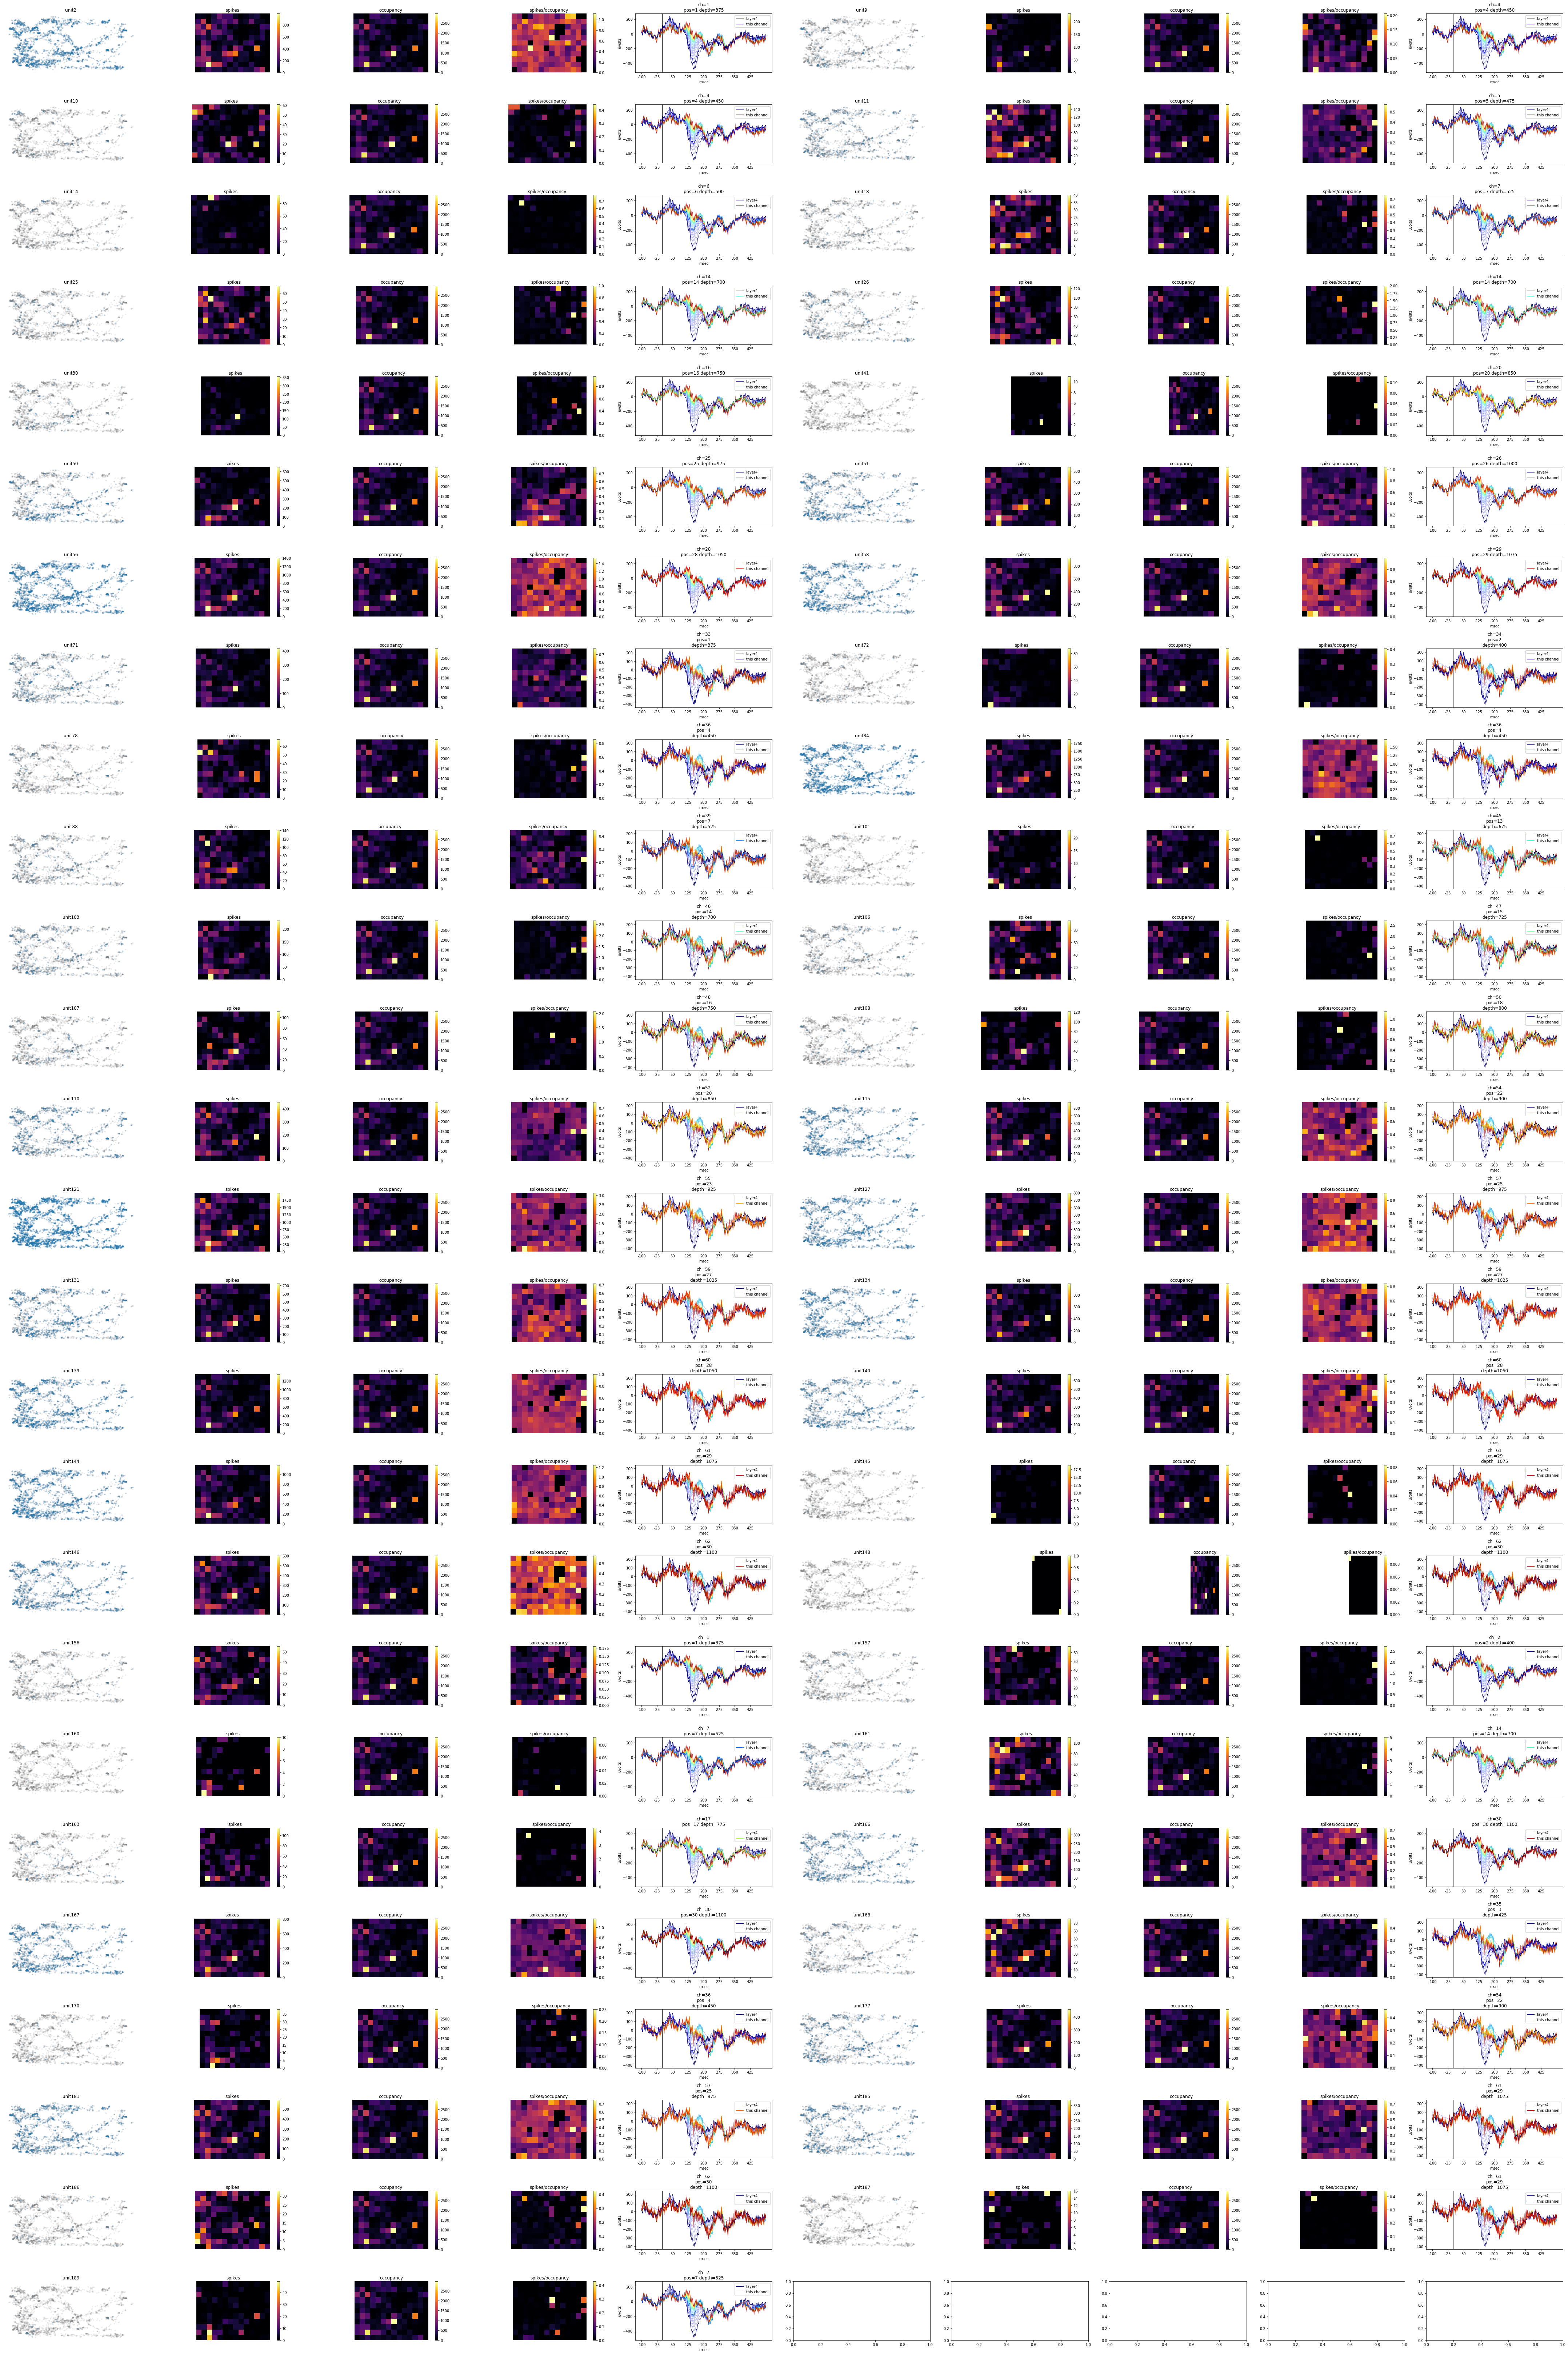

In [62]:
n_units = len(goodcells)
plt.subplots(int(np.ceil(n_units/2)),10, figsize=(60,90))
units = goodcells.index.values
panel_count = 1
unit_count = 1
for i, ind in enumerate(goodcells.index):
    unit_spikes = np.array(goodcells.at[units[i],'spikeT']) # spike times in seconds
    spike_positions = []
    for s in unit_spikes:
        pos_at_spike = [x_trace[int(s*60)], y_trace[int(s*60)]]
        spike_positions.append(pos_at_spike)
    spike_positions = np.array(spike_positions)
    num_bins_x = int(np.ceil(np.nanmax(x_trace) / 50))
    num_bins_y = int(np.ceil(np.nanmax(y_trace) / 50))
    spike_positions = spike_positions[~np.isnan(spike_positions).any(axis=1)]
    xy_trace = np.array([x_trace, y_trace]).T
    xy_trace = xy_trace[~np.isnan(xy_trace).any(axis=1)]
    spike_heatmap, spike_xedges, spike_yedges = np.histogram2d(spike_positions[:,0], spike_positions[:,1], bins=(num_bins_x, num_bins_y))
    total_heatmap, total_xedges, total_yedges = np.histogram2d(xy_trace[:,0], xy_trace[:,1], bins=(num_bins_x, num_bins_y))
    norm_heatmap = spike_heatmap / total_heatmap
    extent = [spike_xedges[0], spike_xedges[-1], spike_yedges[0], spike_yedges[-1]]
    
    plt.subplot(int(np.ceil(n_units/2)),10,panel_count)
    plt.title('unit'+str(ind))
    plt.plot(x_trace[::10], y_trace[::10], '.', c='gray',alpha=0.1)
    plt.plot(spike_positions[::10,0], spike_positions[::10,1], '.', alpha=0.2)
    plt.axis('off')
    panel_count = panel_count + 1
    
    plt.subplot(int(np.ceil(n_units/2)),10,panel_count)
#     spike_heatmap = np.nan_to_num(spike_heatmap, nan=0.0, posinf=0.0, neginf=0.0)
    # hx, hy = norm_heatmap.T.sum(axis=0), norm_heatmap.T.sum(axis=1)
    plt.imshow(spike_heatmap.T, extent=extent, origin='lower', cmap='inferno')
    plt.colorbar(); plt.title('spikes')
    plt.axis('off')
    panel_count = panel_count + 1
    
    plt.subplot(int(np.ceil(n_units/2)),10,panel_count)
#     total_heatmap = np.nan_to_num(total_heatmap, nan=0.0, posinf=0.0, neginf=0.0)
    # hx, hy = norm_heatmap.T.sum(axis=0), norm_heatmap.T.sum(axis=1)
    plt.imshow(total_heatmap.T, extent=extent, origin='lower', cmap='inferno')
    plt.colorbar(); plt.title('occupancy')
    plt.axis('off')
    panel_count = panel_count + 1
    
    plt.subplot(int(np.ceil(n_units/2)),10,panel_count)
    norm_heatmap = np.nan_to_num(norm_heatmap, nan=0.0, posinf=0.0, neginf=0.0)
    # hx, hy = norm_heatmap.T.sum(axis=0), norm_heatmap.T.sum(axis=1)
    plt.imshow(norm_heatmap.T, extent=extent, origin='lower', cmap='inferno')
    plt.colorbar(); plt.title('spikes/occupancy')
    plt.axis('off')
    panel_count = panel_count + 1
    
    plt.subplot(int(np.ceil(n_units/2)),10,panel_count)
    row = revchecker_ephys_data.iloc[i]
    row['probe_name'] = probe
    if np.size(row['hf4_revchecker_revchecker_mean_resp_per_ch'],0) == 64:
        shank_channels = [c for c in range(np.size(row['hf4_revchecker_revchecker_mean_resp_per_ch'], 0)) if int(np.floor(c/32)) == int(np.floor(int(row['ch'])/32))]
        whole_shank = row['hf4_revchecker_revchecker_mean_resp_per_ch'][shank_channels]
        colors = plt.cm.jet(np.linspace(0,1,32))
        for ch_num in range(len(shank_channels)):
            plt.plot(whole_shank[ch_num], color=colors[ch_num], alpha=0.3, linewidth=1) # all other channels
        plt.plot(whole_shank[np.argmin(np.min(whole_shank, axis=1)),:], color=colors[np.argmin(np.min(whole_shank, axis=1))], label='layer4', linewidth=1) # layer 4
    elif np.size(row['hf4_revchecker_revchecker_mean_resp_per_ch'],0) == 16:
        whole_shank = row['hf4_revchecker_revchecker_mean_resp_per_ch']
        colors = plt.cm.jet(np.linspace(0,1,16))
        for ch_num in range(16):
            plt.plot(row['hf4_revchecker_revchecker_mean_resp_per_ch'][ch_num], color=colors[ch_num], alpha=0.3, linewidth=1) # all other channels
        plt.plot(whole_shank[np.argmin(np.min(whole_shank, axis=1)),:], color=colors[np.argmin(np.min(whole_shank, axis=1))], label='layer4', linewidth=1) # layer 4
    else:
        print('unrecognized probe count in LFP plots during unit summary! index='+str(index))
    plt.plot(row['hf4_revchecker_revchecker_mean_resp_per_ch'][row['ch']%32], color=colors[row['ch']%32], label='this channel', linewidth=1) # current channel
    depth_to_layer4 = 350 # microns
    if row['probe_name'] == 'DB_P64-3' or row['probe_name'] == 'DB_P64-8' or row['probe_name'] == 'NN_H64-LP':
        ch_spacing = 25
    elif row['probe_name'] == 'NN_H16':
        ch_spacing = 25
    try:
        if shank_channels[0] == 0:
            position_of_ch = int(row['hf4_revchecker_lfp_rel_depth'][0][row['ch']%32])
            depth_from_surface = int(depth_to_layer4 + (ch_spacing * position_of_ch))
            plt.title('ch='+str(row['ch'])+'\npos='+str(position_of_ch)+' depth='+str(depth_from_surface))
        else:
            position_of_ch = int(row['hf4_revchecker_lfp_rel_depth'][1][row['ch']%32])
            depth_from_surface = int(depth_to_layer4 + (ch_spacing * position_of_ch))
            plt.title('ch='+str(row['ch'])+'\npos='+str(position_of_ch)+'\ndepth='+str(depth_from_surface))
    except KeyError:
        plt.set_title('ch='+str(row['ch']))
    plt.legend(); plt.axvline(x=(0.1*30000), color='k', linewidth=1)
    plt.xticks(np.arange(0,18000,18000/8), labels=np.arange(-100,500,75))
    plt.xlabel('msec'); plt.ylabel('uvolts')
    panel_count = panel_count + 1

plt.tight_layout()
plt.show()